In [11]:
#Assignment 06 — Sentiment Analysis (Tweets)
#Task: Classify tweets about tech companies into Positive or Negative
#Dataset: tweets.csv

# Table of Contents
1.Import Required Libraries
2.Load the Dataset
3.Explore the Dataset (EDA)
4.Data Cleaning & Preprocessing
5.Train–Test Split
6.Feature Engineering (TF‑IDF)
7.Model Building
8.Model Evaluation
9.Predict on New Tweets
10 Conclusion

In [12]:
#import required libraries
import os
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.utils import Bunch

In [3]:
possible_paths = [
    "tweets.csv",
    "/content/tweets.csv"
]

import pandas as pd
import os

df = None
last_err = None
for p in possible_paths:
    if os.path.exists(p):
        try:
            df = pd.read_csv(p)
            print("Loaded:", p)
            break
        except Exception as e:
            last_err = e

if df is None:
    try:
        from google.colab import files  # will work in Colab
        print("Please upload tweets.csv...")
        uploaded = files.upload()
        upname = list(uploaded.keys())[0]
        df = pd.read_csv(upname)
        print("Loaded from upload:", upname)
    except Exception as e:
        raise RuntimeError("Could not load tweets.csv. Make sure it's in the same folder or upload it in Colab.") from e

print("Shape:", df.shape)
print("Columns:", list(df.columns))
df.head(5)

Please upload tweets.csv...


Saving tweets.csv to tweets (1).csv
Loaded from upload: tweets (1).csv
Shape: (7920, 3)
Columns: ['id', 'label', 'tweet']


,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


Using text column: tweet
Using label column: label

Null counts:
tweet    0
label    0
dtype: int64

Class distribution:
label
0    5894
1    2026
Name: count, dtype: int64


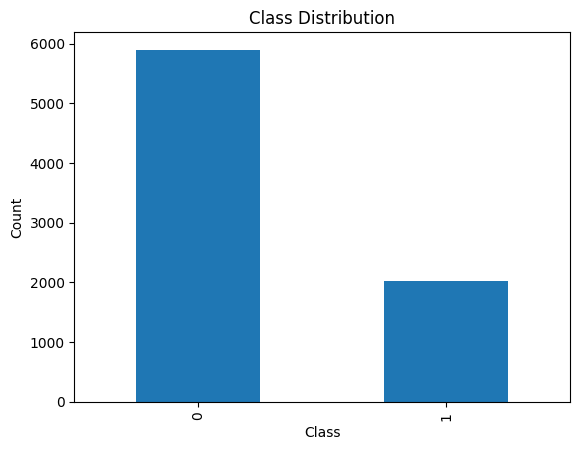

,tweet,label
4896,Photo: cause we both dressed up today  #boyfr...,0
7539,"@skullcandy your product is brutal, 1 headphon...",1
1677,Sunset Today in Zeeland ;-) Samsung Mobile S4 ...,0
1964,God $&@*# it playstation share feature!! Cutti...,0
3025,Awe he's da bestest :) #boyfriend him #iloveyo...,0


In [4]:

text_candidates = [c for c in df.columns if c.lower() in ["text", "tweet", "message", "content"]]
label_candidates = [c for c in df.columns if c.lower() in ["label", "sentiment", "target", "polarity", "class"]]

text_col = text_candidates[0] if text_candidates else df.columns[0]
label_col = label_candidates[0] if label_candidates else df.columns[-1]

print("Using text column:", text_col)
print("Using label column:", label_col)

print("\nNull counts:")
print(df[[text_col, label_col]].isna().sum())

# Basic class distribution
print("\nClass distribution:")
print(df[label_col].value_counts())

# Plot distribution (matplotlib, single plot)
plt.figure()
df[label_col].value_counts().plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# Show sample
df[[text_col, label_col]].sample(min(5, len(df)), random_state=42)

In [5]:
 #Data Cleaning & Preprocessing


import re
import pandas as pd
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def basic_clean(text: str) -> str:
    if not isinstance(text, str):
        text = str(text)
    t = text.lower()
    # remove urls
    t = re.sub(r"http\S+|www\S+", " ", t)
    # remove mentions
    t = re.sub(r"@\w+", " ", t)
    # replace hashtags symbol only
    t = re.sub(r"#", "", t)
    # remove digits
    t = re.sub(r"\d+", " ", t)
    # remove punctuation (keep spaces and word chars)
    t = re.sub(r"[^a-z\s]", " ", t)
    # collapse spaces
    t = re.sub(r"\s+", " ", t).strip()
    return t

def remove_stopwords(text: str) -> str:
    stopwords = set(ENGLISH_STOP_WORDS)
    tokens = [w for w in text.split() if w not in stopwords]
    return " ".join(tokens)

def preprocess_series(s: pd.Series) -> pd.Series:
    return s.fillna("").map(basic_clean).map(remove_stopwords)

df['clean_text'] = preprocess_series(df[text_col])
df[['clean_text', label_col]].head(5)

,clean_text,label
0,fingerprint pregnancy test android apps beauti...,0
1,finally transparant silicon case thanks uncle ...,0
2,love talk makememories unplug relax iphone sma...,0
3,m wired know m george way iphone cute daventry...,0
4,amazing service apple won t talk question unle...,1


In [6]:
 # Train–Test Split

from sklearn.model_selection import train_test_split
import numpy as np

X = df['clean_text'].values
y = df[label_col].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y if len(np.unique(y))>1 else None
)

print("Train size:", len(X_train), " Test size:", len(X_test))

Train size: 6336  Test size: 1584


In [7]:
# Feature Engineering (TF‑IDF)

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    max_features=20000,
    min_df=2
)

# Fit only on train
tfidf.fit(X_train)
X_train_t = tfidf.transform(X_train)
X_test_t  = tfidf.transform(X_test)

X_train_t.shape, X_test_t.shape

((6336, 10293), (1584, 10293))

In [8]:
# Model Building
#
# We'll try three classic baselines:
# - Logistic Regression
# - Multinomial Naive Bayes
# - Linear SVM (LinearSVC)

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

logreg = LogisticRegression(max_iter=200)
nb = MultinomialNB()
svm = LinearSVC()

logreg.fit(X_train_t, y_train)
nb.fit(X_train_t, y_train)
svm.fit(X_train_t, y_train)

print("Models trained.")

Models trained.


Logistic Regression Accuracy: 0.8914

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      1179
           1       0.85      0.70      0.77       405

    accuracy                           0.89      1584
   macro avg       0.88      0.83      0.85      1584
weighted avg       0.89      0.89      0.89      1584

Confusion Matrix:
 [[1129   50]
 [ 122  283]]


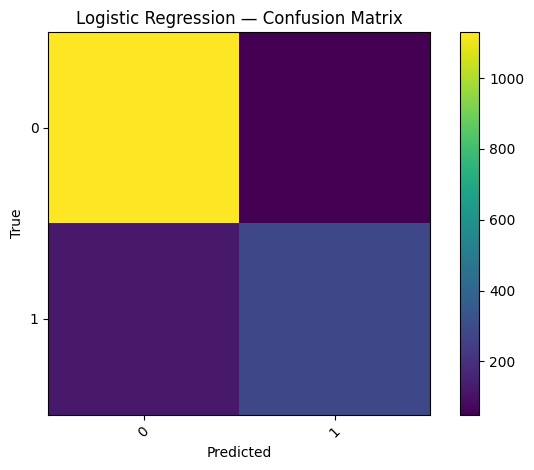

Multinomial NB Accuracy: 0.8832

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1179
           1       0.85      0.66      0.74       405

    accuracy                           0.88      1584
   macro avg       0.87      0.81      0.83      1584
weighted avg       0.88      0.88      0.88      1584

Confusion Matrix:
 [[1133   46]
 [ 139  266]]


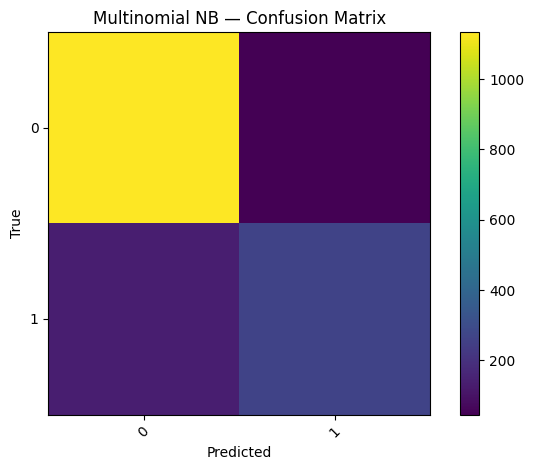

Linear SVM Accuracy: 0.8870

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.93      1179
           1       0.81      0.73      0.77       405

    accuracy                           0.89      1584
   macro avg       0.86      0.84      0.85      1584
weighted avg       0.88      0.89      0.89      1584

Confusion Matrix:
 [[1109   70]
 [ 109  296]]


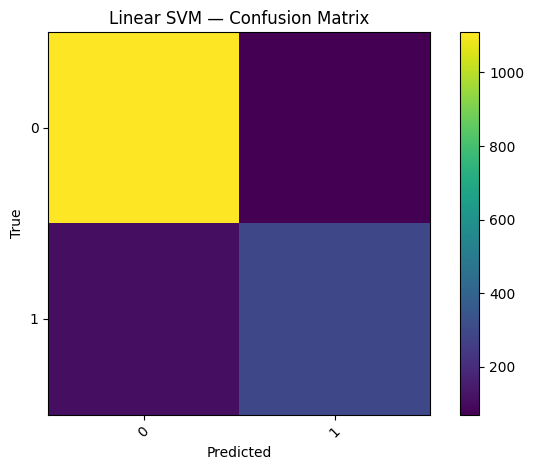

Best model: Logistic Regression


In [9]:
# Model Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

def evaluate(model, X_tr, y_tr, X_te, y_te, name="Model"):
    y_pred = model.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    print(f"{name} Accuracy: {acc:.4f}\n")
    print("Classification Report:")
    print(classification_report(y_te, y_pred))
    cm = confusion_matrix(y_te, y_pred)
    print("Confusion Matrix:\n", cm)
    # Simple confusion matrix plot
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(f"{name} — Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(np.unique(y_te)))
    plt.xticks(tick_marks, np.unique(y_te), rotation=45)
    plt.yticks(tick_marks, np.unique(y_te))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()
    return acc

acc_logreg = evaluate(logreg, X_train_t, y_train, X_test_t, y_test, "Logistic Regression")
acc_nb     = evaluate(nb, X_train_t, y_train, X_test_t, y_test, "Multinomial NB")
acc_svm    = evaluate(svm, X_train_t, y_train, X_test_t, y_test, "Linear SVM")

best_name = ["Logistic Regression","Multinomial NB","Linear SVM"][np.argmax([acc_logreg, acc_nb, acc_svm])]
print("Best model:", best_name)

In [10]:
# Predict on New Tweets

samples = [
    "I love this phone! Battery life is amazing and camera is great.",
    "Worst laptop ever. Keeps crashing and support is useless.",
]

samples_clean = [remove_stopwords(basic_clean(s)) for s in samples]
samples_vec = tfidf.transform(samples_clean)

print("LogReg predictions:", logreg.predict(samples_vec))
print("NB predictions:", nb.predict(samples_vec))
print("SVM predictions:", svm.predict(samples_vec))

LogReg predictions: [0 1]
NB predictions: [0 1]
SVM predictions: [0 1]


#Conclusion
We built a complete sentiment analysis pipeline for tweets: cleaning → TF‑IDF → models.
Reported accuracy and full metrics for 3 classic models.